BONUS ZADATAK IZ KVANTNE FIZIKE

Izračunajte koeficijente transmisije i refleksije za raspršenje čestice na Heaviside-Lambda 
potencijalu

$$V(x) =
\begin{cases}
  - \dfrac{V_0}{a} \big( |x|-a \big), & |x| \leq a \\
  0, & |x| > a \\
\end{cases}$$

Usporedite analitičke i numeričke rezultate. Usporedite rezultate s pravokutnom jamom iste širine i dubine. Uputa: Kod analitičkog rješenja treba koristiti Airy-eve funkcije prve i druge vrste (mogu se pronači u scipy.special modulu pod nazivom Airy
https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.airy.html )

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import brentq
from scipy.special import airy
from scipy.integrate import simps,quad
from scipy.integrate import odeint

In [2]:
A=8.6375   #m/hbar
B=13.12    #m/hbar**2
hbar=A/B
m=A*hbar

In [3]:
V_0=10
a=10
l=(a*hbar**2/(2*m*V_0))**(1./3.)

In [4]:
def point1(l,lam):
    Ai,Aip,Bi,Bip=airy(a/l-lam) #vraca vrijednosti funkcija Ai, Bi i njihove derivacije
    return Ai,Aip,Bi,Bip


def point2(lam):
    Ai,Aip,Bi,Bip=airy(-lam) #vraca vrijednosti funkcija Ai, Bi i njihove derivacije
    return Ai,Aip,Bi,Bip

    
def E_F(k,lam):
    Ai,Aip,Bi,Bip=point1(l,lam)
    n= np.exp(1j*k*a)/(Ai*Bip-Aip*Bi)
    E=(Bip - 1j*k*l*Bi)*n
    F=(-Aip + 1j*k*l*Ai)*n
    return E,F


def C_D(k,lam):
    E,F=E_F(k,lam)
    Ai,Aip,Bi,Bip=point2(lam)
    n= 1/(Ai*Bip-Aip*Bi)
    p= Ai*Bip+Aip*Bi
    C=(2*F*Bi*Bip + E*p)*n
    D=(-2*E*Ai*Aip - F*p)*n
    return C,D


def A(k,lam):
    C,D=C_D(k,lam)
    Ai,Aip,Bi,Bip=point1(l,lam)
    A=0.5*C*(Ai+1j*Aip/(k*l))+0.5*D*(Bi+1j*Bip/(k*l))
    return A

def jama(k1,k2):
    T=(4*k1**2*k2**2)/(4*k1**2*k2**2+(np.sin(k2*2*a))**2*(k1**2-k2**2)**2)
    return T
#poznato rjesenje za transmisiju na  potencijalnoj jami

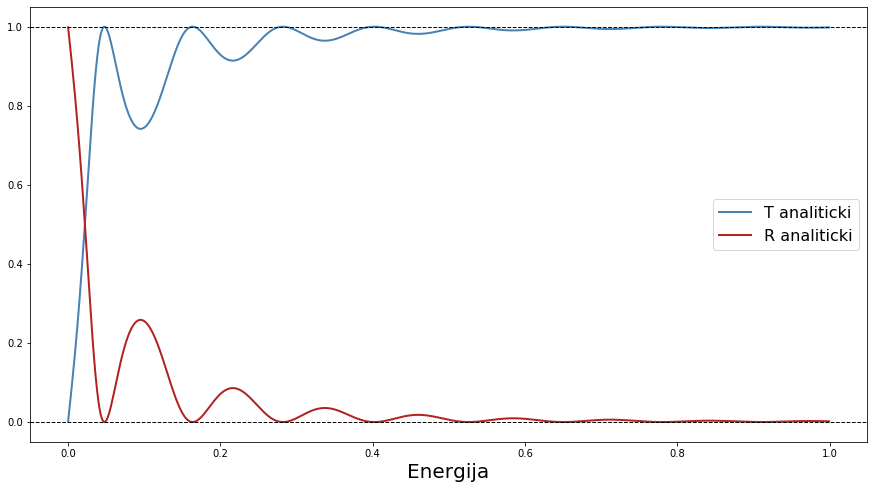

In [5]:
Energije = np.arange(0.0001,1.,0.001)
k= np.sqrt(2*m*Energije/hbar**2)
lam=2*m*(Energije+V_0)*l**2/hbar**2
koef=abs(A(k,lam))
T=(1/koef)**2
fig1=plt.figure(1,figsize=(15,8))
plt.plot(Energije,T,color='steelblue',lw=2,ls='-',label='T analiticki')
plt.plot(Energije,1-T,color='firebrick',lw=2,ls='-',label='R analiticki')
plt.axhline(y=0.0,ls='--',c='k',lw=1.0)
plt.axhline(y=1.0,ls='--',c='k',lw=1.0)
plt.xlabel('Energija',fontsize=20)
plt.legend(fontsize=16)

In [6]:
def V(x):
    if x<-a or x>a:
        pot=0
    else:
        pot=V_0/a*(np.sign(x)*x-a)
    return pot

In [7]:
Xmin=-20.0   #krajnja tocka na lijevoj strani 
Xmax= 20.0   #krajnja tocka na desnoj strani 
step=0.01   #korak mreze
xmesh=np.arange(Xmax,Xmin,-step)    #ukupna mreza
potencijal=[V(i) for i in xmesh]
Npts=len(xmesh)

In [8]:
def func(y,x,e):
    v=V(x)
    f1R=y[0]
    f1I=y[1]
    f2R=y[2]
    f2I=y[3]
    fac1=f2R
    fac2=f2I
    fac3=-2*m*(e-v)*f1R/hbar**2
    fac4=-2*m*(e-v)*f1I/hbar**2
    return [fac1,fac2,fac3,fac4]

In [9]:
tkoef=[]
rkoef=[]
for E in Energije:
    k=np.sqrt(2*m*E)/hbar
    y0=[np.cos(k*Xmax),np.sin(k*Xmax),-k*np.sin(k*Xmax),k*np.cos(k*Xmax)] 
    y=odeint(func,y0,xmesh,args=(E,))
    yR=y[Npts-1,0]
    yI=y[Npts-1,1]
    dyR=y[Npts-1,2]
    dyI=y[Npts-1,3]
    c=np.cos(k*Xmin)
    s=np.sin(k*Xmin)
    ks=k*s
    kc=k*c
    A=np.zeros([4,4],float)
    b=np.zeros([4],float)
    A[0,0]=c
    A[0,1]=-s
    A[0,2]=c
    A[0,3]=s
    A[1,0]=s
    A[1,1]=c
    A[1,2]=-s
    A[1,3]=c
    A[2,0]=-ks
    A[2,1]=-kc
    A[2,2]=-ks
    A[2,3]=kc
    A[3,0]=kc
    A[3,1]=-ks
    A[3,2]=-kc
    A[3,3]=-ks
    b[0]=yR
    b[1]=yI
    b[2]=dyR
    b[3]=dyI

    sol=np.linalg.solve(A,b)
    AR=sol[0]
    AI=sol[1]
    BR=sol[2]
    BI=sol[3]
    
    tkoef.append(1/(AR**2+AI**2))
    rkoef.append((BR**2+BI**2)/(AR**2+AI**2))
    
tkoef=np.array(tkoef)
rkoef=np.array(rkoef)

Text(0.5, 0, 'Energija')

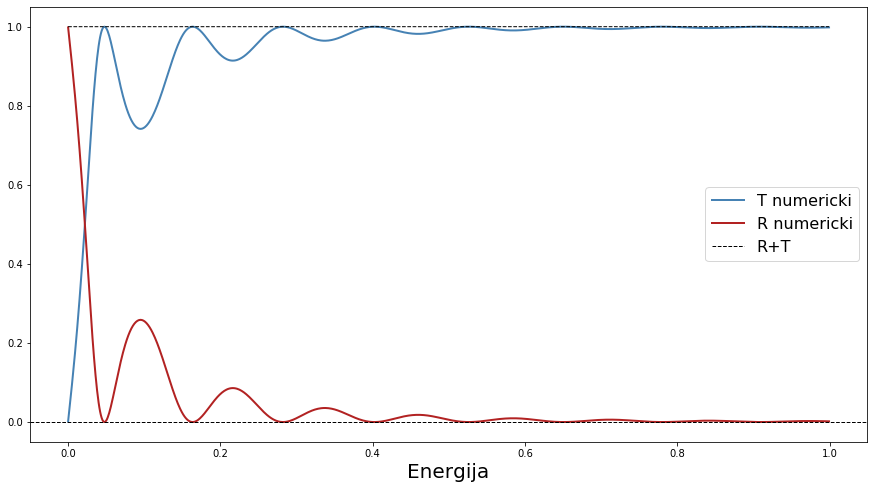

In [10]:
Nmax=len(Energije)
fig2=plt.figure(1,figsize=(15,8))
Emax=Energije[Nmax-1]
plt.plot(Energije,tkoef,color='steelblue',lw=2,ls='-',label='T numericki')
plt.plot(Energije,rkoef,color='firebrick',lw=2,ls='-',label='R numericki')
plt.plot(Energije,rkoef+tkoef,color='k',ls='--',lw=1,label='R+T')
plt.axhline(y=0.0,ls='--',c='k',lw=1.0)
plt.legend(fontsize=16)
plt.xlabel('Energija',fontsize=20)

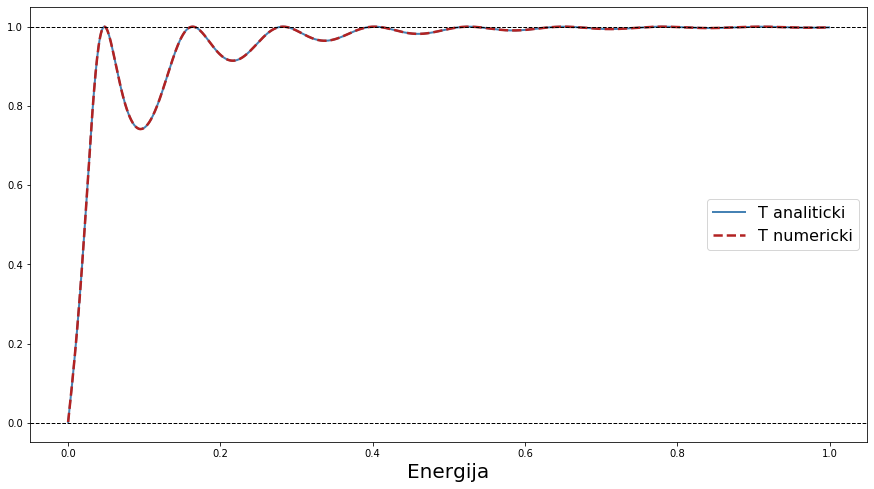

In [11]:
fig2=plt.figure(1,figsize=(15,8))
plt.plot(Energije,T,color='steelblue',lw=2,ls='-',label='T analiticki')
plt.plot(Energije,tkoef,color='firebrick',lw=2.5,ls='--',label='T numericki')
plt.axhline(y=0.0,ls='--',c='k',lw=1.0)
plt.axhline(y=1.0,ls='--',c='k',lw=1.0)
plt.xlabel('Energija',fontsize=20)
plt.legend(fontsize=16)

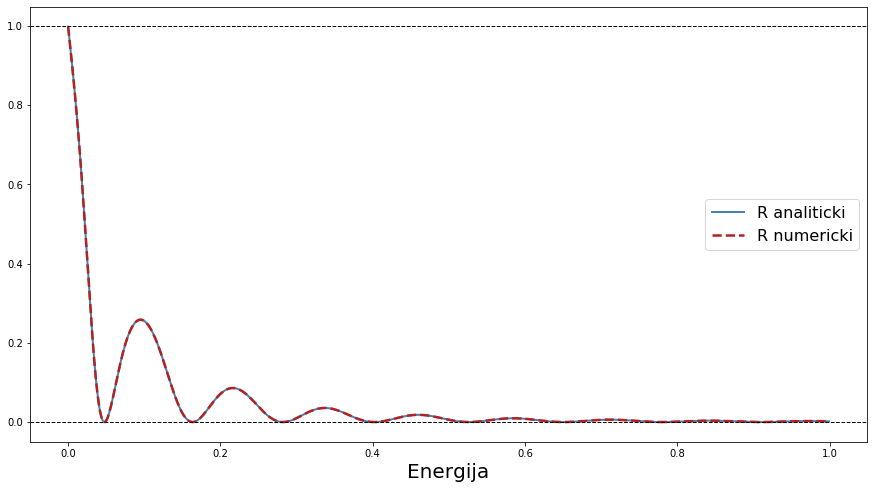

In [12]:
fig2=plt.figure(1,figsize=(15,8))
plt.plot(Energije,1-T,color='steelblue',lw=2,ls='-',label='R analiticki')
plt.plot(Energije,rkoef,color='firebrick',lw=2.5,ls='--',label='R numericki')
plt.axhline(y=0.0,ls='--',c='k',lw=1.0)
plt.axhline(y=1.0,ls='--',c='k',lw=1.0)
plt.xlabel('Energija',fontsize=20)
plt.legend(fontsize=16)

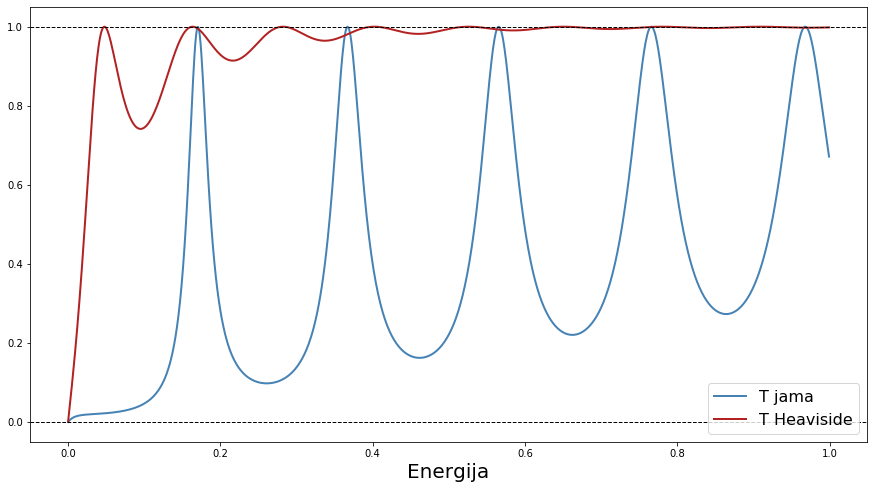

In [13]:
k1= np.sqrt(2*m*Energije/hbar**2)
k2= np.sqrt(2*m*(Energije+V_0)/hbar**2)
jama_T=jama(k1,k2)
fig1=plt.figure(1,figsize=(15,8))
plt.plot(Energije,jama_T,color='steelblue',lw=2,ls='-',label='T jama')
plt.plot(Energije,tkoef,color='firebrick',lw=2,ls='-',label='T Heaviside')
plt.axhline(y=0.0,ls='--',c='k',lw=1.0)
plt.axhline(y=1.0,ls='--',c='k',lw=1.0)
plt.xlabel('Energija',fontsize=20)
plt.legend(fontsize=16)

In [15]:
#trnjenje koeficijenta transmisije u jedinicu je puno brže kod Heaviside-Lambda potencijala 
#u usporedbi sa potencijalom iste sirine i dubine